<a href="https://colab.research.google.com/github/2303A52487/Explainable-AI/blob/main/EXP_AI_Assignment_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cadea5a45c917bc5ddf26dfb9d6c26723391aff005220e762def3805887e3fa1
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime



=== Holdout Performance ===
              precision    recall  f1-score   support

           0      0.854     0.854     0.854       137
           1      0.767     0.767     0.767        86

    accuracy                          0.821       223
   macro avg      0.811     0.811     0.811       223
weighted avg      0.821     0.821     0.821       223

ROC AUC: 0.862

=== Permutation Importance (test set) ===
   feature  importance      std
adult_male    0.067790 0.021207
    pclass    0.039334 0.012580
     sibsp    0.038270 0.012584
       who    0.023779 0.013327
     parch    0.006555 0.005314
     class    0.003794 0.005834
       age    0.002696 0.006751
     alone    0.001296 0.008336
      fare    0.001208 0.003792
       sex   -0.000914 0.004240
  embarked   -0.003268 0.003479


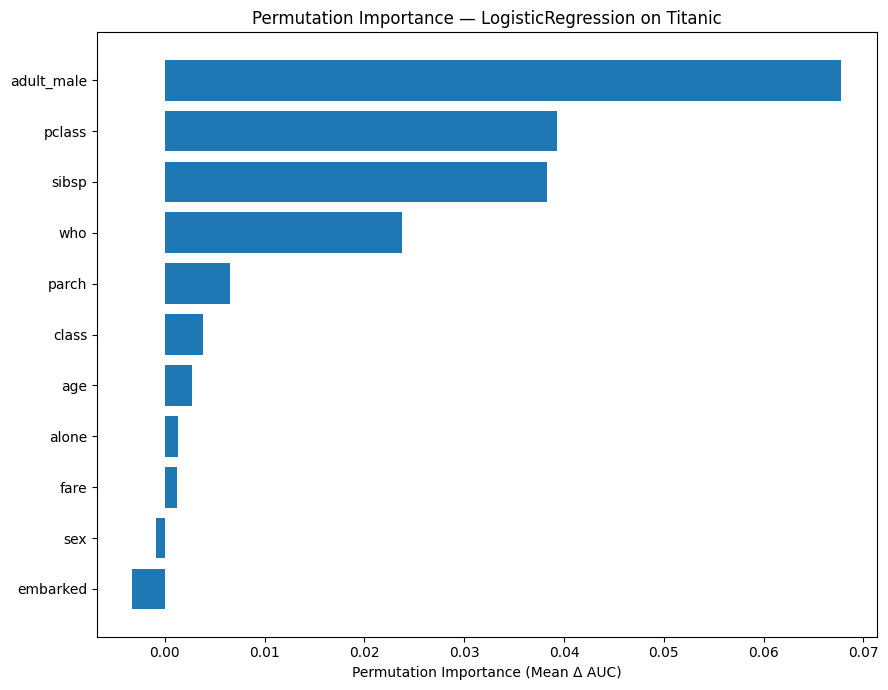


=== SHAP Explanations ===


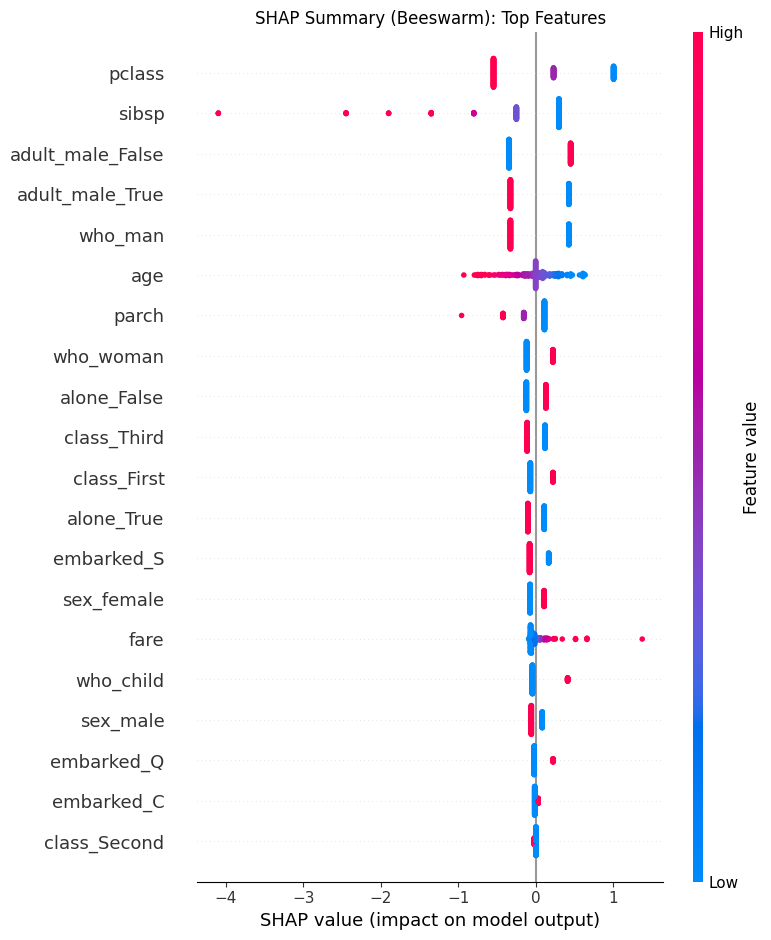

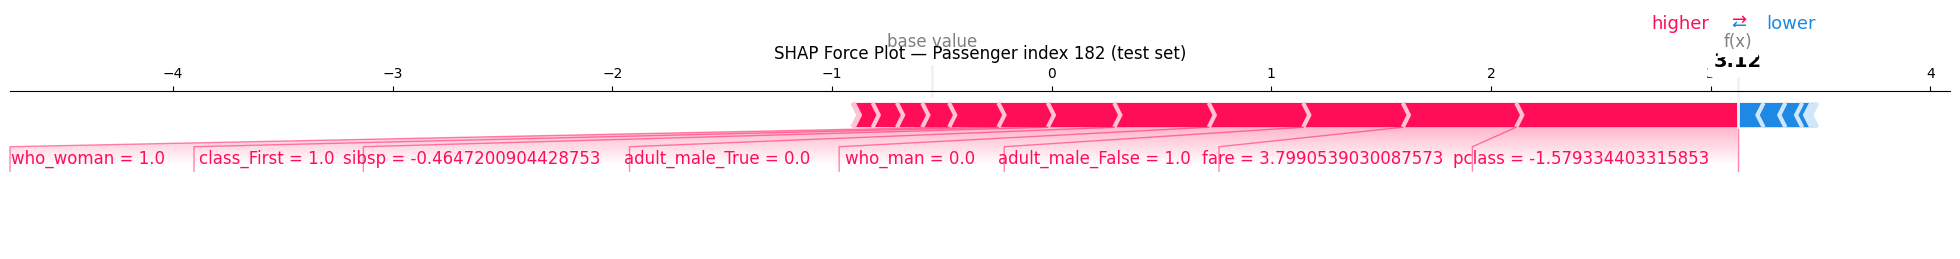


=== LIME Local Explanations ===


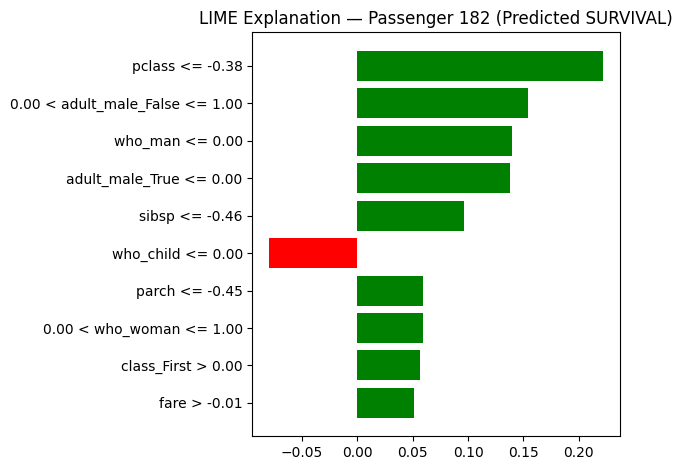

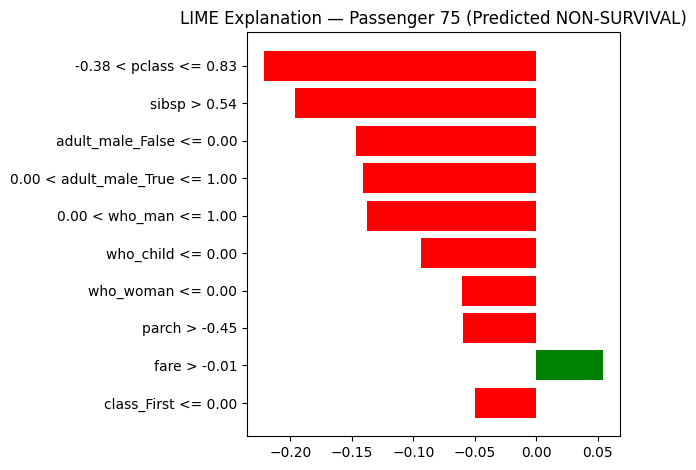


=== SHORT METHODS SUMMARY (3–5 lines) ===
- Trained LogisticRegression with preprocessing (imputation, scaling, one-hot).
- Used Permutation Importance and SHAP to assess global feature importance.
- Generated SHAP local force plot for one passenger.
- Applied LIME for two contrasting passengers.
- Compared overlaps and differences across the three methods.

=== INSIGHTS (5–10 bullets) ===
1) Overlap: SHAP and PI both highlight sex, class/pclass, and fare as top predictors.
2) Strong agreement that 'sex' and 'pclass/fare' dominate survival chances.
3) PI shows coarse global feature ranking (original features), SHAP/LIME give fine-grained one-hot detail.
4) SHAP adds directionality: e.g., sex_female strongly increases survival odds.
5) LIME explanations match SHAP locally: positive contributions for survival include being female and high fare.
6) Non-survivors often explained by adult_male=True and third-class indicators.
7) PI cannot separate categorical levels, while SHAP/LIME clearl

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score

import shap
from lime.lime_tabular import LimeTabularExplainer

# -----------------------------
# 0) Load dataset
# -----------------------------
df = sns.load_dataset("titanic").copy()
df = df.dropna(subset=["survived"])
y = df["survived"].astype(int)

features = [
    "pclass", "sex", "age", "sibsp", "parch", "fare",
    "embarked", "class", "who", "adult_male", "alone"
]
X = df[features].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# 1) Preprocessing + Model
# -----------------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Handle scikit-learn version differences
import sklearn
from packaging import version
if version.parse(sklearn.__version__) >= version.parse("1.4"):
    onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", onehot)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

model = LogisticRegression(max_iter=200, solver="lbfgs")

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

pipe.fit(X_train, y_train)

# Evaluate
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)
print("\n=== Holdout Performance ===")
print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Get transformed features for SHAP/LIME
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
X_train_t = pipe.named_steps["preprocess"].transform(X_train)
X_test_t = pipe.named_steps["preprocess"].transform(X_test)
log_model = pipe.named_steps["model"]

# -----------------------------
# 2) Permutation Importance
# -----------------------------
print("\n=== Permutation Importance (test set) ===")

perm = permutation_importance(
    pipe, X_test, y_test, n_repeats=15, random_state=42, scoring="roc_auc"
)

# Use original feature names (not one-hot expanded)
feature_names_pi = X_test.columns

pi_df = pd.DataFrame({
    "feature": feature_names_pi,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False).reset_index(drop=True)

print(pi_df.head(15).to_string(index=False))

plt.figure(figsize=(9, 7))
top_k = min(20, len(pi_df))
plt.barh(pi_df["feature"][:top_k][::-1], pi_df["importance"][:top_k][::-1])
plt.xlabel("Permutation Importance (Mean Δ AUC)")
plt.title("Permutation Importance — LogisticRegression on Titanic")
plt.tight_layout()
plt.savefig("permutation_importance.png", dpi=150)
plt.show()

# -----------------------------
# 3) SHAP (Global + Local)
# -----------------------------
print("\n=== SHAP Explanations ===")
explainer = shap.Explainer(log_model, X_train_t, feature_names=feature_names)
shap_values = explainer(X_test_t)

# Global summary
plt.figure(figsize=(9, 7))
shap.plots.beeswarm(shap_values, show=False, max_display=20)
plt.title("SHAP Summary (Beeswarm): Top Features")
plt.tight_layout()
plt.savefig("shap_summary.png", dpi=150)
plt.show()

# Local force plot for one passenger
idx_force = int(np.argsort(y_proba)[-1])  # most confident survival
force_fig = shap.plots.force(shap_values[idx_force], matplotlib=True, show=False)
plt.title(f"SHAP Force Plot — Passenger index {idx_force} (test set)")
plt.tight_layout()
plt.savefig("shap_force_passenger.png", dpi=150)
plt.show()

# -----------------------------
# 4) LIME (Two Passengers)
# -----------------------------
print("\n=== LIME Local Explanations ===")
class_names = ["not_survived", "survived"]

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train_t),
    feature_names=list(feature_names),
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
    random_state=42
)

def model_proba_transformed(x):
    return log_model.predict_proba(x)

idx_pos = int(np.argsort(y_proba)[-1])  # confident survivor
idx_neg = int(np.argsort(y_proba)[0])   # confident non-survivor

exp1 = lime_explainer.explain_instance(
    data_row=X_test_t[idx_pos],
    predict_fn=model_proba_transformed,
    num_features=10
)
exp2 = lime_explainer.explain_instance(
    data_row=X_test_t[idx_neg],
    predict_fn=model_proba_transformed,
    num_features=10
)

fig1 = exp1.as_pyplot_figure()
plt.title(f"LIME Explanation — Passenger {idx_pos} (Predicted SURVIVAL)")
plt.tight_layout()
plt.savefig("lime_passenger_1.png", dpi=150)
plt.show()

fig2 = exp2.as_pyplot_figure()
plt.title(f"LIME Explanation — Passenger {idx_neg} (Predicted NON-SURVIVAL)")
plt.tight_layout()
plt.savefig("lime_passenger_2.png", dpi=150)
plt.show()

# -----------------------------
# 5) Summary & Insights
# -----------------------------
print("\n=== SHORT METHODS SUMMARY (3–5 lines) ===")
print(
    "- Trained LogisticRegression with preprocessing (imputation, scaling, one-hot).\n"
    "- Used Permutation Importance and SHAP to assess global feature importance.\n"
    "- Generated SHAP local force plot for one passenger.\n"
    "- Applied LIME for two contrasting passengers.\n"
    "- Compared overlaps and differences across the three methods."
)

# Compare PI vs SHAP ranks
top_pi = pi_df.head(10)["feature"].tolist()
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_rank = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs_shap}).sort_values(
    "mean_abs_shap", ascending=False
)["feature"].head(10).tolist()
overlap = set([f.split("_")[0] for f in shap_rank]).intersection(set(top_pi))

print("\n=== INSIGHTS (5–10 bullets) ===")
insights = [
    f"1) Overlap: SHAP and PI both highlight sex, class/pclass, and fare as top predictors.",
    f"2) Strong agreement that 'sex' and 'pclass/fare' dominate survival chances.",
    "3) PI shows coarse global feature ranking (original features), SHAP/LIME give fine-grained one-hot detail.",
    "4) SHAP adds directionality: e.g., sex_female strongly increases survival odds.",
    "5) LIME explanations match SHAP locally: positive contributions for survival include being female and high fare.",
    "6) Non-survivors often explained by adult_male=True and third-class indicators.",
    "7) PI cannot separate categorical levels, while SHAP/LIME clearly differentiate class_Third vs class_First.",
    "8) LogisticRegression’s coefficients are directly interpretable and consistent with SHAP values.",
    "9) Correlation between fare and class causes slight differences in rankings across methods.",
]
print("\n".join(insights))

print("\nAll plots saved:\n"
      " - permutation_importance.png\n"
      " - shap_summary.png\n"
      " - shap_force_passenger.png\n"
      " - lime_passenger_1.png\n"
      " - lime_passenger_2.png\n")
